In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FactorAnalysis
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE
import itertools
import plotly.graph_objects as go
from collections import Counter

sns.set_theme(style='darkgrid', palette='dark')
warnings.filterwarnings('ignore')

In [107]:
# Nous chargons le dataframme correspondant a l'agglomération des clients en une ligne.
# Nous évalurons les différentes méthodes de clustering sur ces données et leurs qualité dans ce documents.
# Nos données s'étalent sur 2 ans (2016-10-11 au 2018-10-17). Pour étudier ensuite la stabilité de notre clustering,
# nous généraliserons en fin de notebook a des séparation en 2 (tout les ans), en 4 (tout les 6 mois)
# et en 8 (tout les trimestre) pour lesquels nous chercherons également les meilleurs paramètres.
# L'ensemble de nos fonction seront faite sur une liste de dataframmes
# pour faciliter la généralisation finale.

df_final = pd.read_csv('df_final').drop(columns='Unnamed: 0')
data_avec_date = pd.read_csv('data_avec_date.csv')


# les fonctions tournerons sur des listes de dataframmes, on prends donc le data de l'ensemble des données pour en faire
# un clustering dbscan et kmean :
liste_data = [df_final]

<AxesSubplot:ylabel='Count'>

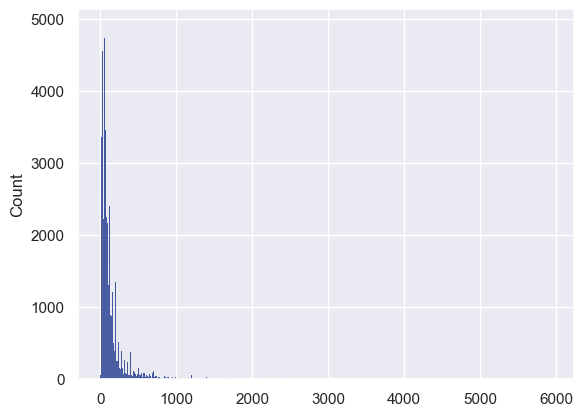

In [3]:
# Regardons la répartition de différentes features pour commencer, et les
# corrélations entre elles :

sns.histplot(df_final.sort_values(by='price')['price'].tolist()[:-10])

<AxesSubplot:xlabel='total_number_product_bought', ylabel='Count'>

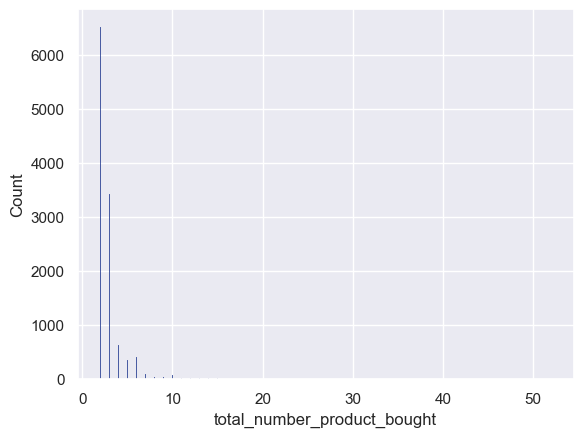

In [4]:
sns.histplot(df_final.loc[df_final['total_number_product_bought']
             > 1]['total_number_product_bought'])

<AxesSubplot:xlabel='number_of_order_made', ylabel='Count'>

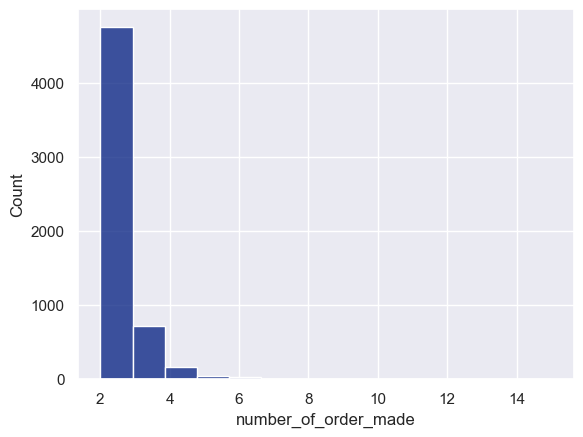

In [5]:
sns.histplot(
    df_final.loc[df_final['number_of_order_made'] > 1]['number_of_order_made'])

<AxesSubplot:xlabel='review_score', ylabel='Count'>

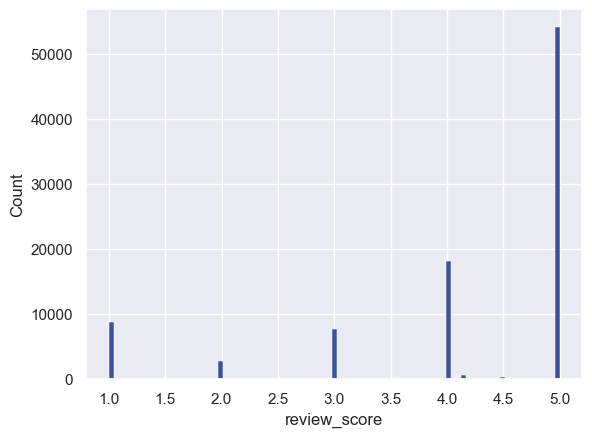

In [6]:
sns.histplot(df_final['review_score'])

<AxesSubplot:>

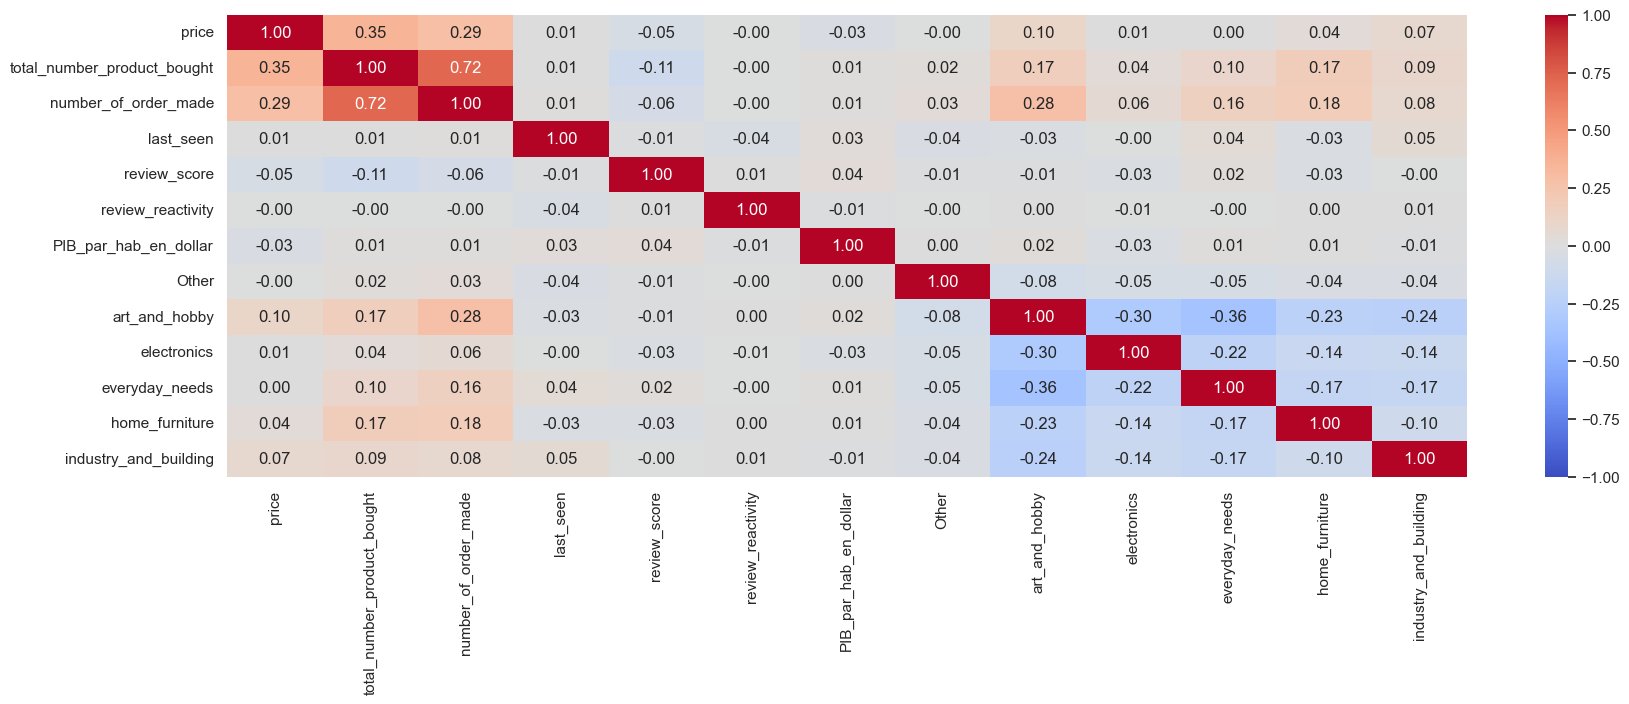

In [7]:
correlations = df_final.corr()
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(
    correlations,
    vmin=-1,
    vmax=1,
    annot=True,
    cmap="coolwarm",
    fmt="0.2f")

In [109]:
# Commençons par créer les différentes fonctions permettant de choisir les paramètres du Dbscan et du Kmean que nous
# allons comparer.

# Certaines features resterons à l'état de renseignement lors de l'analyse des clusters, mais ne sera pas utilisé pour
# faire le clustering, d'ou les deux fonction de scalerisation :

def scaler(data):
    x = data.iloc[:, 1:].drop(columns=['review_reactivity',
                                       'Other',
                                       'art_and_hobby',
                                       'electronics',
                                       'everyday_needs',
                                       'home_furniture',
                                       'industry_and_building',
                                       'total_number_product_bought'])
    data_cr = data.copy(deep=True).drop(columns=['review_reactivity',
                                                 'Other',
                                                 'art_and_hobby',
                                                 'electronics',
                                                 'everyday_needs',
                                                 'home_furniture',
                                                 'industry_and_building',
                                                 'total_number_product_bought'])
    scaler = StandardScaler()
    scaler.fit(x)
    X_cr = scaler.transform(x)
    data_cr.iloc[:, 1:] = X_cr
    return data_cr.iloc[:, 1:]


def scaler2(data):
    x = data.iloc[:, 1:]
    data_cr = data.copy(deep=True)
    scaler = StandardScaler()
    scaler.fit(x)
    X_cr = scaler.transform(x)
    data_cr.iloc[:, 1:] = X_cr
    return data_cr.iloc[:, 1:]

# une fonction pour récuperer le nombre de client par période selon les
# séparations :


def shape_data_par_periode(liste_data):
    df = pd.DataFrame()
    compteur = 1
    for i in liste_data:
        df[f'Shape_periode_{compteur}'] = [i.shape[0]]
        compteur += 1
    return df.T.rename(columns={df.T.columns[0]: 'Shapes'})

# Et pour finir deux fonctions de décision des paramètres du kmean et du
# dbscan:


def inertie_kmean(liste_data):
    if len(liste_data) > 1:
        fig, ax = plt.subplots(len(liste_data), figsize=(20, 15))
    k_list = range(1, 17)
    compteur = 1
    for i in liste_data:
        i = scaler(i)
        intertia_list = []
        for k in k_list:
            kmeans = KMeans(n_clusters=k)
            kmeans.fit(i)
            intertia_list.append(kmeans.inertia_)
        if len(liste_data) > 1:
            plt.sca(ax[compteur - 1])
        plt.plot(k_list, intertia_list)
        plt.ylabel("intertie totale")
        plt.xlabel(f"n_cluster periode {compteur}")
        compteur += 1


def get_kdist_plot_liste_dataframe(
        liste_data, k, radius_nbrs=1.0, metric='minkowski'):
    if len(liste_data) > 1:
        fig, ax = plt.subplots(len(liste_data), figsize=(20, 15))
    compteur = 1
    for i in liste_data:
        i = scaler(i)
        nbrs = NearestNeighbors(
            n_neighbors=k,
            radius=radius_nbrs,
            metric=metric).fit(i)
        distances, indices = nbrs.kneighbors(i)
        distances = np.sort(distances, axis=0)
        distances = distances[:, k - 1]
        distances = np.where(distances < 15, distances, 15)
        if len(liste_data) > 1:
            plt.sca(ax[compteur - 1])
        plt.plot(distances)
        plt.xlabel(
            f"Distance entre chaque point et son {k}ième plus proche voisin, période{compteur}")
        plt.yticks(np.arange(0, 17, 2))
        plt.ylabel(f"distance")
        compteur += 1

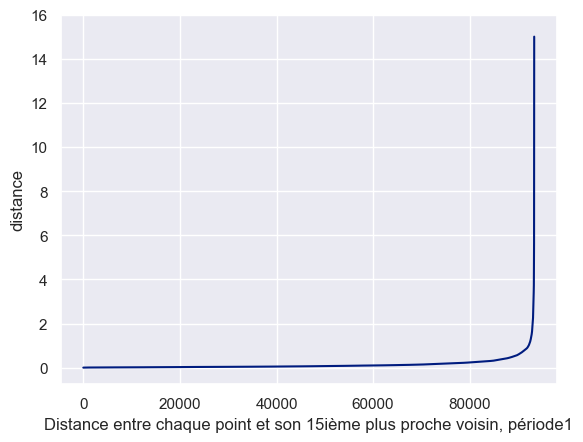

In [9]:
# Cette dernière fonction propose le graphique dela distance entre chaque point et son 15ème plus proche voisin.
# Les premières valeurs ont été retiré, la distance étant très proche de 0, pour ne garder que les plus grande valeurs.
# Ainsi, on peut lire à quel moment la distance entre un point et son 15ème plus proche voisin augmente drastiquement.
# Celà nous permet de choisir le paramètre Epsilon pour le dbscan.
get_kdist_plot_liste_dataframe(liste_data, 15, metric='l2')

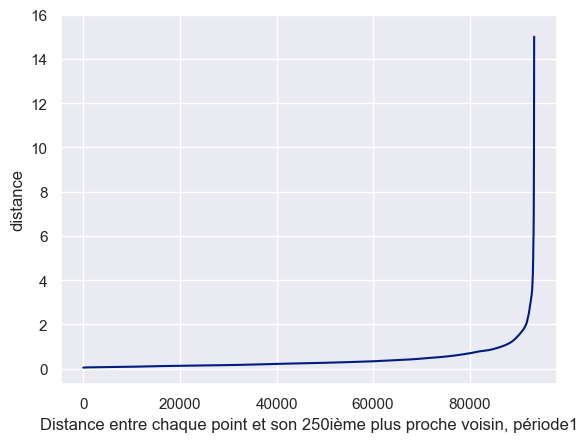

In [10]:
get_kdist_plot_liste_dataframe(liste_data, 250, metric='l2')

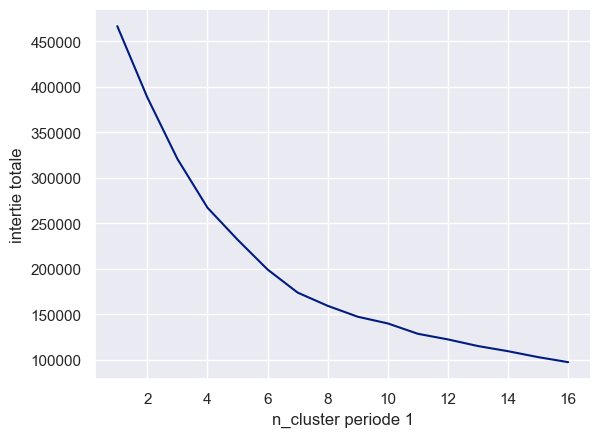

In [11]:
# Pour le kmean, pour choisir le nombre de cluster au total, nous allons utilier la même méthode du coude que pour le dbscan
# avec l'intertie totale en fonction du nombre de cluster.
inertie_kmean(liste_data)

In [12]:
# On regarde les tailles des séparations des clients pour décider du nombre minimal de points devant être dans la range
# d'un autre pour le dbscan. On choisira un millième de notre population
# de chaque dataset (min sample).
shape_data_par_periode(liste_data)

,Shapes
Shape_periode_1,93350


In [19]:
# On sétup les paramètres pour les périodes souhaités (non automatisé)
# avec les méthodes du coude des graphiques précédents
n_cluster_kmean = [7]
min_sample_dbscan = [47]
eps_dbscan = [0.85]

In [110]:
# On crée ici l'ensemble des fonction permettant le clustering, et d'ensuite étudier le clustering avec la silhouette.
# On étudira la qualité d'un clustering sur une unique période, ainsi que
# la stabilité sur plusieurs périodes.

def kmean_for_one(data, n_cluster):
    kmeans = KMeans(n_clusters=n_cluster)
    kmeans.fit(data)
    dic = {i: 'Cl{}'.format(i) for i in range(n_cluster)}
    labels_kmean = [dic[i] for i in kmeans.labels_]
    return labels_kmean


def dbscan_for_one(data, min_samples, eps):
    dbscan = DBSCAN(min_samples=min_samples, eps=eps, algorithm='ball_tree')
    dbscan_label = dbscan.fit_predict(data)
    dic = {i: 'Cl{}'.format(i) for i in np.unique(dbscan_label)}
    labels_dbscan = [dic[i] for i in dbscan_label]
    return labels_dbscan

# On crée une fonction qui récapitule les labels selon les période et le
# type de clustering :


def recapitulatif_cluster(liste_data,
                          list_n_cluster,
                          list_min_sample,
                          list_eps_dbscan):
    cluster = pd.DataFrame()
    cluster['id_client'] = df_final['customer_unique_id']
    compteur = 0
    for i in liste_data:
        df = pd.DataFrame()
        df['id_user'] = i['customer_unique_id']
        df[f'Result_kmean_periode_{compteur+1}'] = kmean_for_one(
            scaler(i), list_n_cluster[compteur])
        df[f'Result_dbscan_periode_{compteur+1}'] = dbscan_for_one(
            scaler(i), list_min_sample[compteur], list_eps_dbscan[compteur])
        cluster = cluster.set_index('id_client').join(
            df.set_index('id_user')).reset_index()
        compteur += 1
    return cluster

# Voici maintenant une fonction décrivant les clusters


def description_clustering(data, periode, type_cluster):
    df_final_cr = scaler2(df_final.copy(deep=True))
    df_final_cr['customer_unique_id'] = df_final['customer_unique_id']

    df = data.set_index('id_client').join(
        df_final_cr.set_index('customer_unique_id')).reset_index()
    coordonees = df.groupby(
        'Result_' +
        type_cluster +
        '_periode_' +
        str(periode)).mean()

    fig, ax = plt.subplots(figsize=(20, 6))
    sns.heatmap(
        coordonees.T,
        vmin=-3,
        vmax=3,
        annot=True,
        cmap="coolwarm",
        fmt="0.2f")
    plt.title(
        "Variation en nombre d'écart type par rapport à la moyenne des données de toutes périodes",
        fontsize=20)
    nb_par_cluster = df.groupby(
        'Result_' + type_cluster + '_periode_' + str(periode)
    ).count()['id_client'].to_frame().rename(columns={'id_client': 'Population_du_cluster'}).T
    nb_par_cluster['total'] = [data.loc[~data['Result_' +
                                              type_cluster +
                                              '_periode_' + 
                                              str(periode)].isna()].shape[0]]

    return nb_par_cluster


def silhouette(liste_data):
    df = pd.DataFrame()
    compteur = 0
    for i in liste_data:
        data_cr = scaler(i)
        df[f'Silhouette_for_kmean_periode{compteur+1}'] = [silhouette_score(data_cr,
                                                                            df_cluster_final.loc[
                                                                                ~df_cluster_final['Result_kmean_periode_' + str(
                                                                                    compteur + 1)].isna(),
                                                                                'Result_kmean_periode_' + str(compteur + 1)])]
        df[f'Silhouette_for_dbscan_periode{compteur+1}'] = [silhouette_score(data_cr,
                                                                             df_cluster_final.loc[
                                                                                 ~df_cluster_final['Result_dbscan_periode_' + str(
                                                                                     compteur + 1)].isna(),
                                                                                 'Result_dbscan_periode_' + str(compteur + 1)])]
        compteur += 1
    return df.T.rename(columns={df.T.columns[0]: 'Silhouette_score'})

In [111]:
# Commençons par crée, pour chaque client, l'ensemble des labels donnés par les deux algorithmes de clustering sur l'ensemble
# des périodes.
df_cluster_final = recapitulatif_cluster(liste_data,
                                         n_cluster_kmean,
                                         min_sample_dbscan,
                                         eps_dbscan)
df_cluster_final

,id_client,Result_kmean_periode_1,Result_dbscan_periode_1
0,0000366f3b9a7992bf8c76cfdf3221e2,Cl0,Cl0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,Cl0,Cl0
2,0004bd2a26a76fe21f786e4fbd80607f,Cl0,Cl0
3,00050ab1314c0e55a6ca13cf7181fecf,Cl0,Cl0
4,00053a61a98854899e70ed204dd4bafe,Cl4,Cl-1
...,...,...,...
47339,fff2ae16b99c6f3c785f0e052f2a9cfb,Cl0,Cl0
47340,fff3e1d7bc75f11dc7670619b2e61840,Cl2,Cl0
47341,fff5eb4918b2bf4b2da476788d42051c,Cl3,Cl-1
47342,fff96bc586f78b1f070da28c4977e810,Cl1,Cl0


In [15]:
# Etudions maintenant, au lieu de voir graphiquement les paramètres, différentes possibilités pour ceux ci, en regardant leur
# silhouette score pour juger de la qualité du clustering :

df = pd.DataFrame()
for i in [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]:
    data_cr = scaler(liste_data[0])
    label_kmean = kmean_for_one(data_cr, i)
    df[f'Kmean_periode_0_&_k={i}'] = [silhouette_score(data_cr, label_kmean)]
df = df.T.rename(columns={df.T.columns[0]: 'Silhouette_score'})
df.sort_values(by='Silhouette_score', ascending=False)

,Silhouette_score
Kmean_periode_0_&_k=9,0.355760
Kmean_periode_0_&_k=8,0.350988
Kmean_periode_0_&_k=10,0.346544
Kmean_periode_0_&_k=7,0.345421
Kmean_periode_0_&_k=11,0.340304
Kmean_periode_0_&_k=6,0.326103
Kmean_periode_0_&_k=12,0.320151
Kmean_periode_0_&_k=5,0.312317
Kmean_periode_0_&_k=14,0.308255
Kmean_periode_0_&_k=13,0.300247


In [125]:
# Et pour le dbscan :

df = pd.DataFrame()
liste_number_cluster = []
for i in [45, 35, 25, 15]:
    for k in [0.5, 0.8, 1, 1.2]:
        data_cr = scaler(liste_data[0])
        label_dbscan = dbscan_for_one(data_cr, i, k)
        label_df = pd.DataFrame(label_dbscan)
        nb_cluster = len(label_df[label_df.columns[0]].unique())
        liste_number_cluster.append(nb_cluster)
        df[f'Dbscan_periode_0_&_epsilon={k}_&_min_sample={i}'] = [
            silhouette_score(data_cr, label_dbscan)]
df = df.T.rename(columns={df.T.columns[0]: 'Silhouette_score'})
df['Number_of_cluster'] = liste_number_cluster
df = df.sort_values(by='Silhouette_score', ascending=False)
df

,Silhouette_score,Number_of_cluster
Dbscan_periode_0_&_epsilon=1.2_&_min_sample=15,0.471759,6
Dbscan_periode_0_&_epsilon=1.2_&_min_sample=25,0.471728,5
Dbscan_periode_0_&_epsilon=1.2_&_min_sample=45,0.471245,5
Dbscan_periode_0_&_epsilon=1_&_min_sample=15,0.471225,5
Dbscan_periode_0_&_epsilon=1.2_&_min_sample=35,0.470931,5
Dbscan_periode_0_&_epsilon=1_&_min_sample=35,0.468535,5
Dbscan_periode_0_&_epsilon=1_&_min_sample=25,0.466282,6
Dbscan_periode_0_&_epsilon=1_&_min_sample=45,0.465235,5
Dbscan_periode_0_&_epsilon=0.8_&_min_sample=15,0.463338,6
Dbscan_periode_0_&_epsilon=0.8_&_min_sample=35,0.458461,5


In [126]:
# Voici donc notre clustering final sur l'ensemble des données :
df_cluster_final = recapitulatif_cluster(liste_data,
                                         [8],
                                         [25],
                                         [1.2])
df_cluster_final

,id_client,Result_kmean_periode_1,Result_dbscan_periode_1
0,0000366f3b9a7992bf8c76cfdf3221e2,Cl1,Cl0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,Cl1,Cl0
2,0004bd2a26a76fe21f786e4fbd80607f,Cl1,Cl0
3,00050ab1314c0e55a6ca13cf7181fecf,Cl1,Cl0
4,00053a61a98854899e70ed204dd4bafe,Cl4,Cl1
...,...,...,...
47336,fff2ae16b99c6f3c785f0e052f2a9cfb,Cl1,Cl0
47337,fff3e1d7bc75f11dc7670619b2e61840,Cl0,Cl0
47338,fff5eb4918b2bf4b2da476788d42051c,Cl5,Cl0
47339,fff96bc586f78b1f070da28c4977e810,Cl7,Cl0


Result_dbscan_periode_1,Cl-1,Cl0,Cl1,Cl2,Cl3,total
Population_du_cluster,420,43805,1922,1004,190,47341


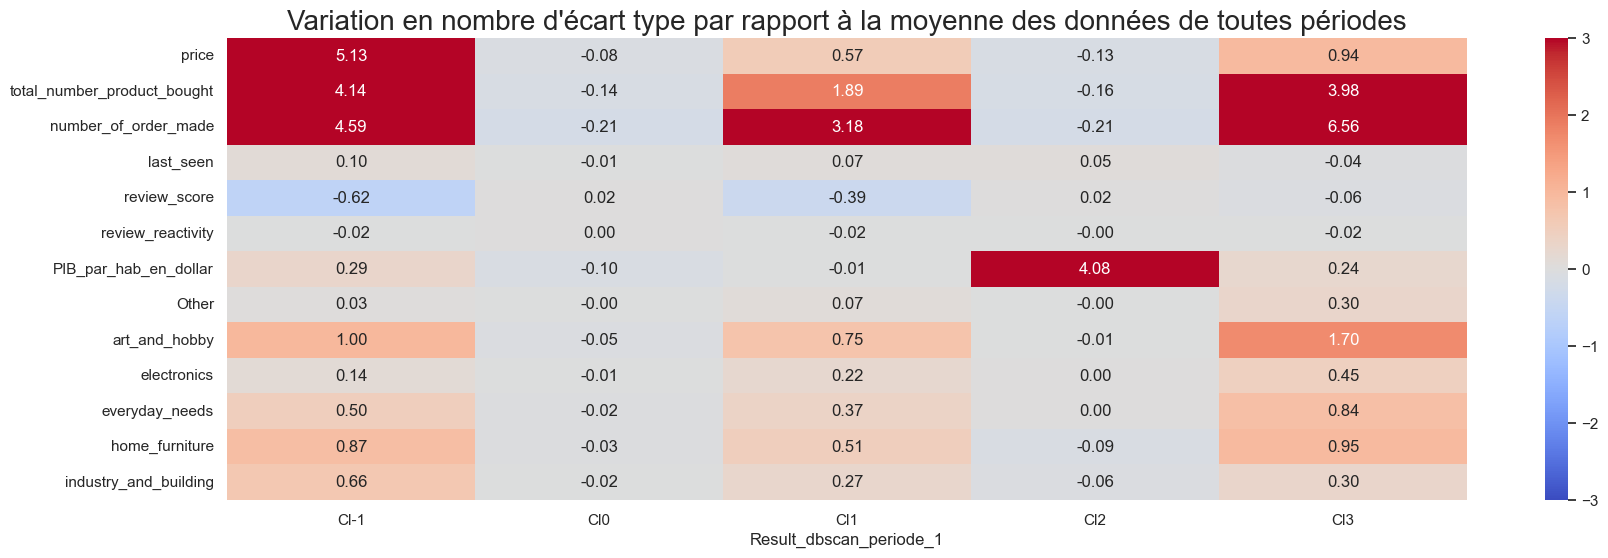

In [127]:
# Nous pouvons regarder un par un les caractéristiques des cluster, selon la période et le type de cluster.
# La heatmap corresponds au nombre d'écart type par rapport à la moyenne de toutes les data pour la feature en question.
# Les coordonées très fortes ou très faibles font la caractéristique du
# cluster.
description_clustering(df_cluster_final, 1, 'dbscan')

In [100]:
def reshape_comme_je_veux(a):
    reshaped1 = []
    reshaped2 = []
    for i in a:
        reshaped1.append(i[0])
        reshaped2.append(i[1])
    return [reshaped1, reshaped2]


def test_model(feature, clustering):
    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(feature)    
    fig, ax = plt.subplots(figsize=(14, 5))
    sns.scatterplot(reshape_comme_je_veux(X_tsne)[0],
                    reshape_comme_je_veux(X_tsne)[1], 
                    hue = clustering)
    plt.legend(bbox_to_anchor=(0.5, -0.2), borderaxespad=0)
    plt.title("2 first componant of TSNE")
    plt.xlabel("F1")
    plt.ylabel("F2")
    

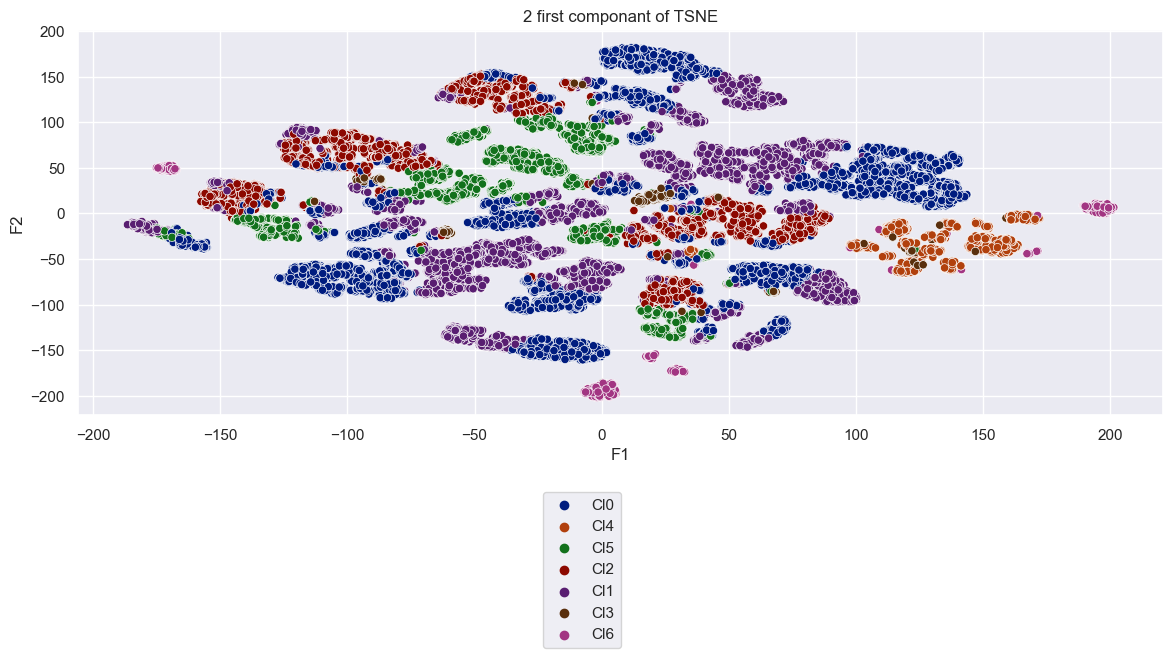

In [113]:
test_model(scaler2(df_final).values, df_cluster_final['Result_kmean_periode_1'])

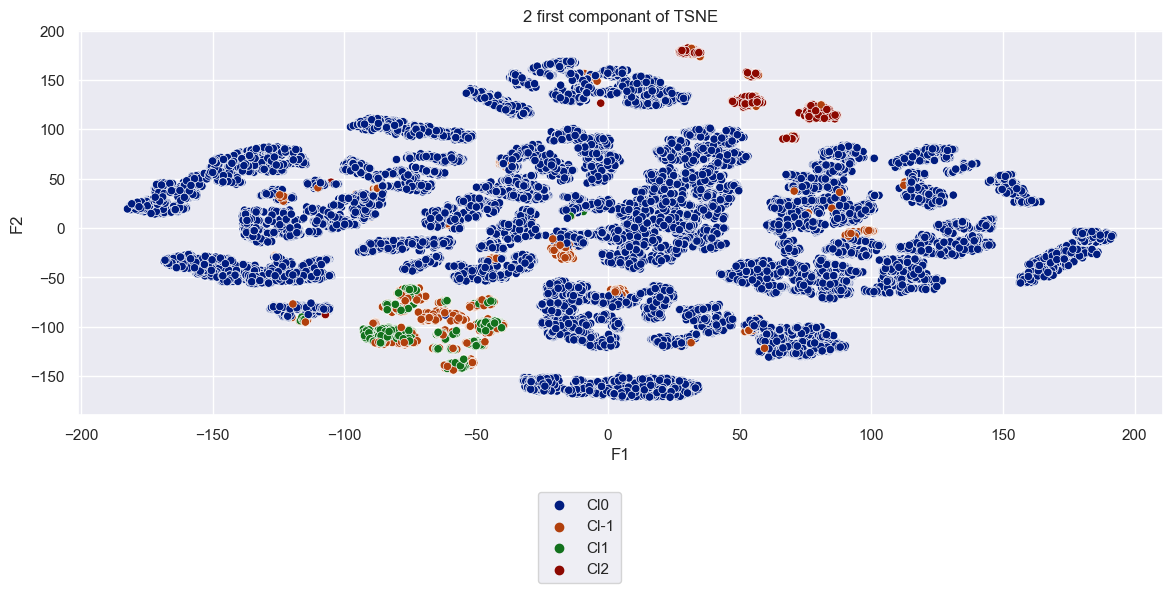

In [114]:
test_model(scaler2(df_final).values, df_cluster_final['Result_dbscan_periode_1'])

Result_kmean_periode_1,Cl0,Cl1,Cl2,Cl3,Cl4,Cl5,Cl6,total
Population_du_cluster,34058,1229,16392,22261,5431,12001,1978,93350


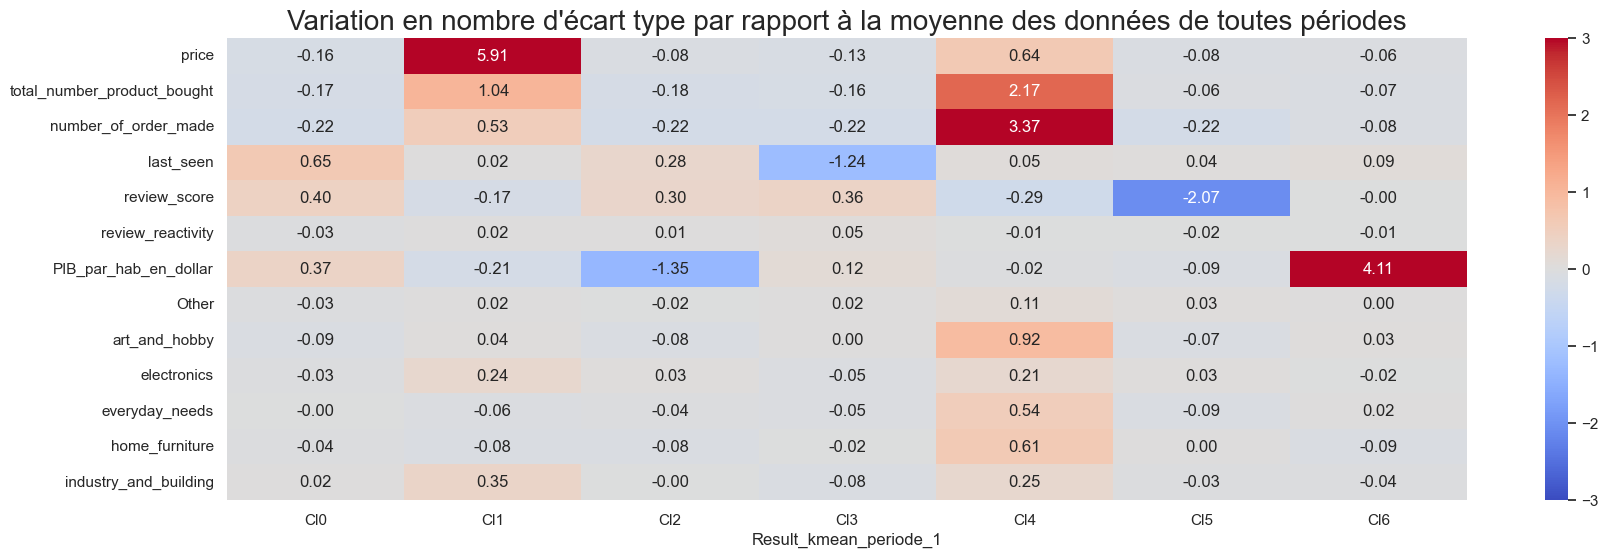

In [22]:
description_clustering(df_cluster_final, 1, 'kmean')

In [24]:
# Etudions maintenant les répartitions par feature à l'aide de boxplot :

def ranger_cluster_ordre(liste):
    i = 0
    liste_ordonee = []
    frequency = Counter(liste)
    if frequency['Cl-1'] > 0:
        liste_ordonee.append('Cl-1')
    for i in range(len(liste) + 100):
        if frequency['Cl' + str(i)] > 0:
            liste_ordonee.append('Cl' + str(i))
    return liste_ordonee

def number_of_box_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    mask = (series < Q1 - 1.5 * IQR) | (series > Q3 + 1.5 * IQR)
    number_of_outliers = series[mask].shape[0]
    return number_of_outliers


def boxplot(data, periode, type_cluster, feature):
    df_final_cr = df_final.copy(deep=True)
    df = data.set_index('id_client').join(
        df_final_cr.set_index('customer_unique_id')).reset_index()
    liste_cluster = ranger_cluster_ordre(list(df['Result_' + type_cluster + '_periode_' + str(periode)].unique()))
    num_outliers = []
    fig, ax = plt.subplots(nrows=len(liste_cluster),figsize=(10, 35))
    for count, i in enumerate(liste_cluster):
        num_outliers.append(number_of_box_outliers(df.loc[df['Result_' + type_cluster + '_periode_' + str(periode)] == i][feature]))
        plt.sca(ax[count])    
        plt.boxplot(df.loc[df['Result_' + type_cluster + '_periode_' + str(periode)] == i][feature],
                    vert = False,
                    labels = [feature])
        plt.title(f'{feature} boxplot for {i}')
    nb_par_cluster = df.groupby(
        'Result_' + type_cluster + '_periode_' + str(periode)
    ).count()['id_client'].to_frame().rename(columns={'id_client': 'Population_du_cluster'}).T
    nb_par_cluster['total'] = [data.loc[~data['Result_' +
                                              type_cluster +
                                              '_periode_' + 
                                              str(periode)].isna()].shape[0]]

    num_outliers.append(' ')
    nb_par_cluster.loc['Nombre_outliers'] = num_outliers

    return nb_par_cluster




Result_kmean_periode_1,Cl0,Cl1,Cl2,Cl3,Cl4,Cl5,Cl6,total
Population_du_cluster,34058,1229,16392,22261,5431,12001,1978,93350
Nombre_outliers,2329,87,1302,1713,276,941,156,


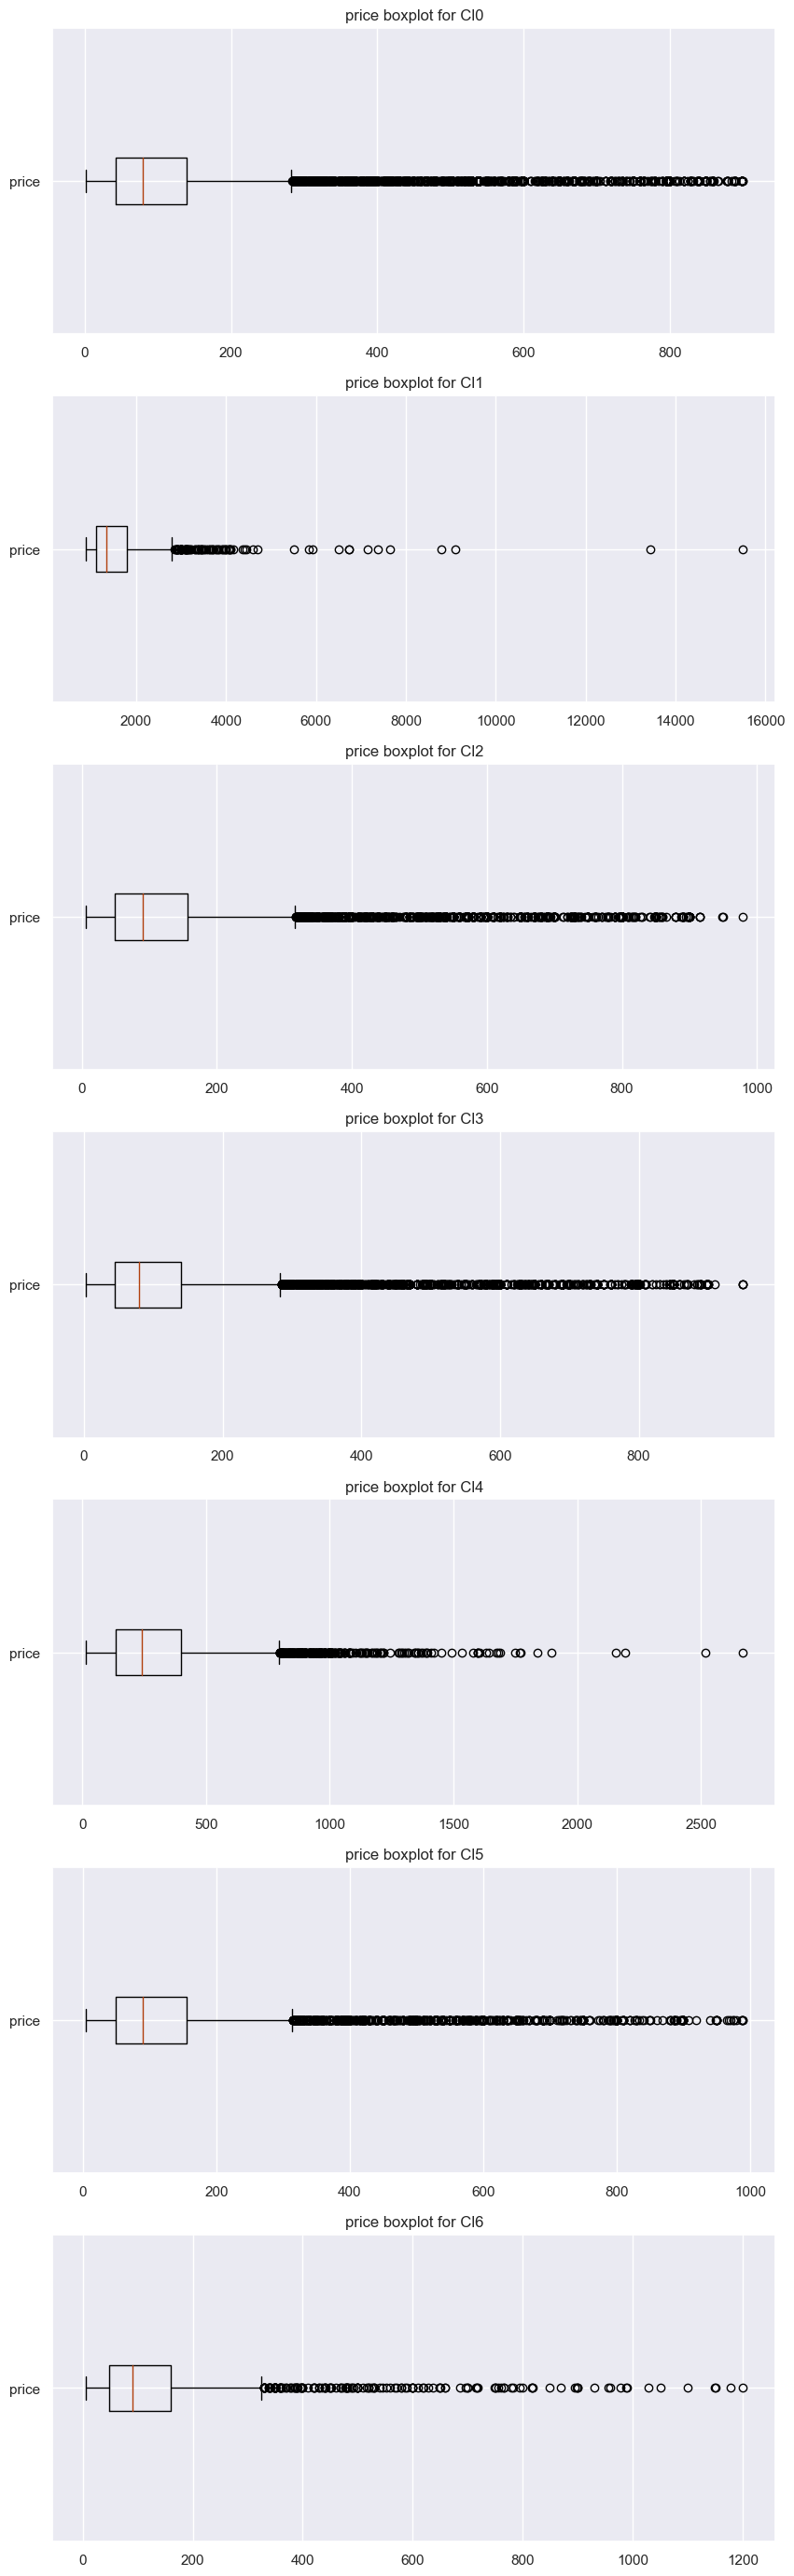

In [25]:
boxplot(df_cluster_final, 1, 'kmean', 'price')

Result_kmean_periode_1,Cl0,Cl1,Cl2,Cl3,Cl4,Cl5,Cl6,total
Population_du_cluster,34058,1229,16392,22261,5431,12001,1978,93350
Nombre_outliers,0,197,0,0,901,0,99,


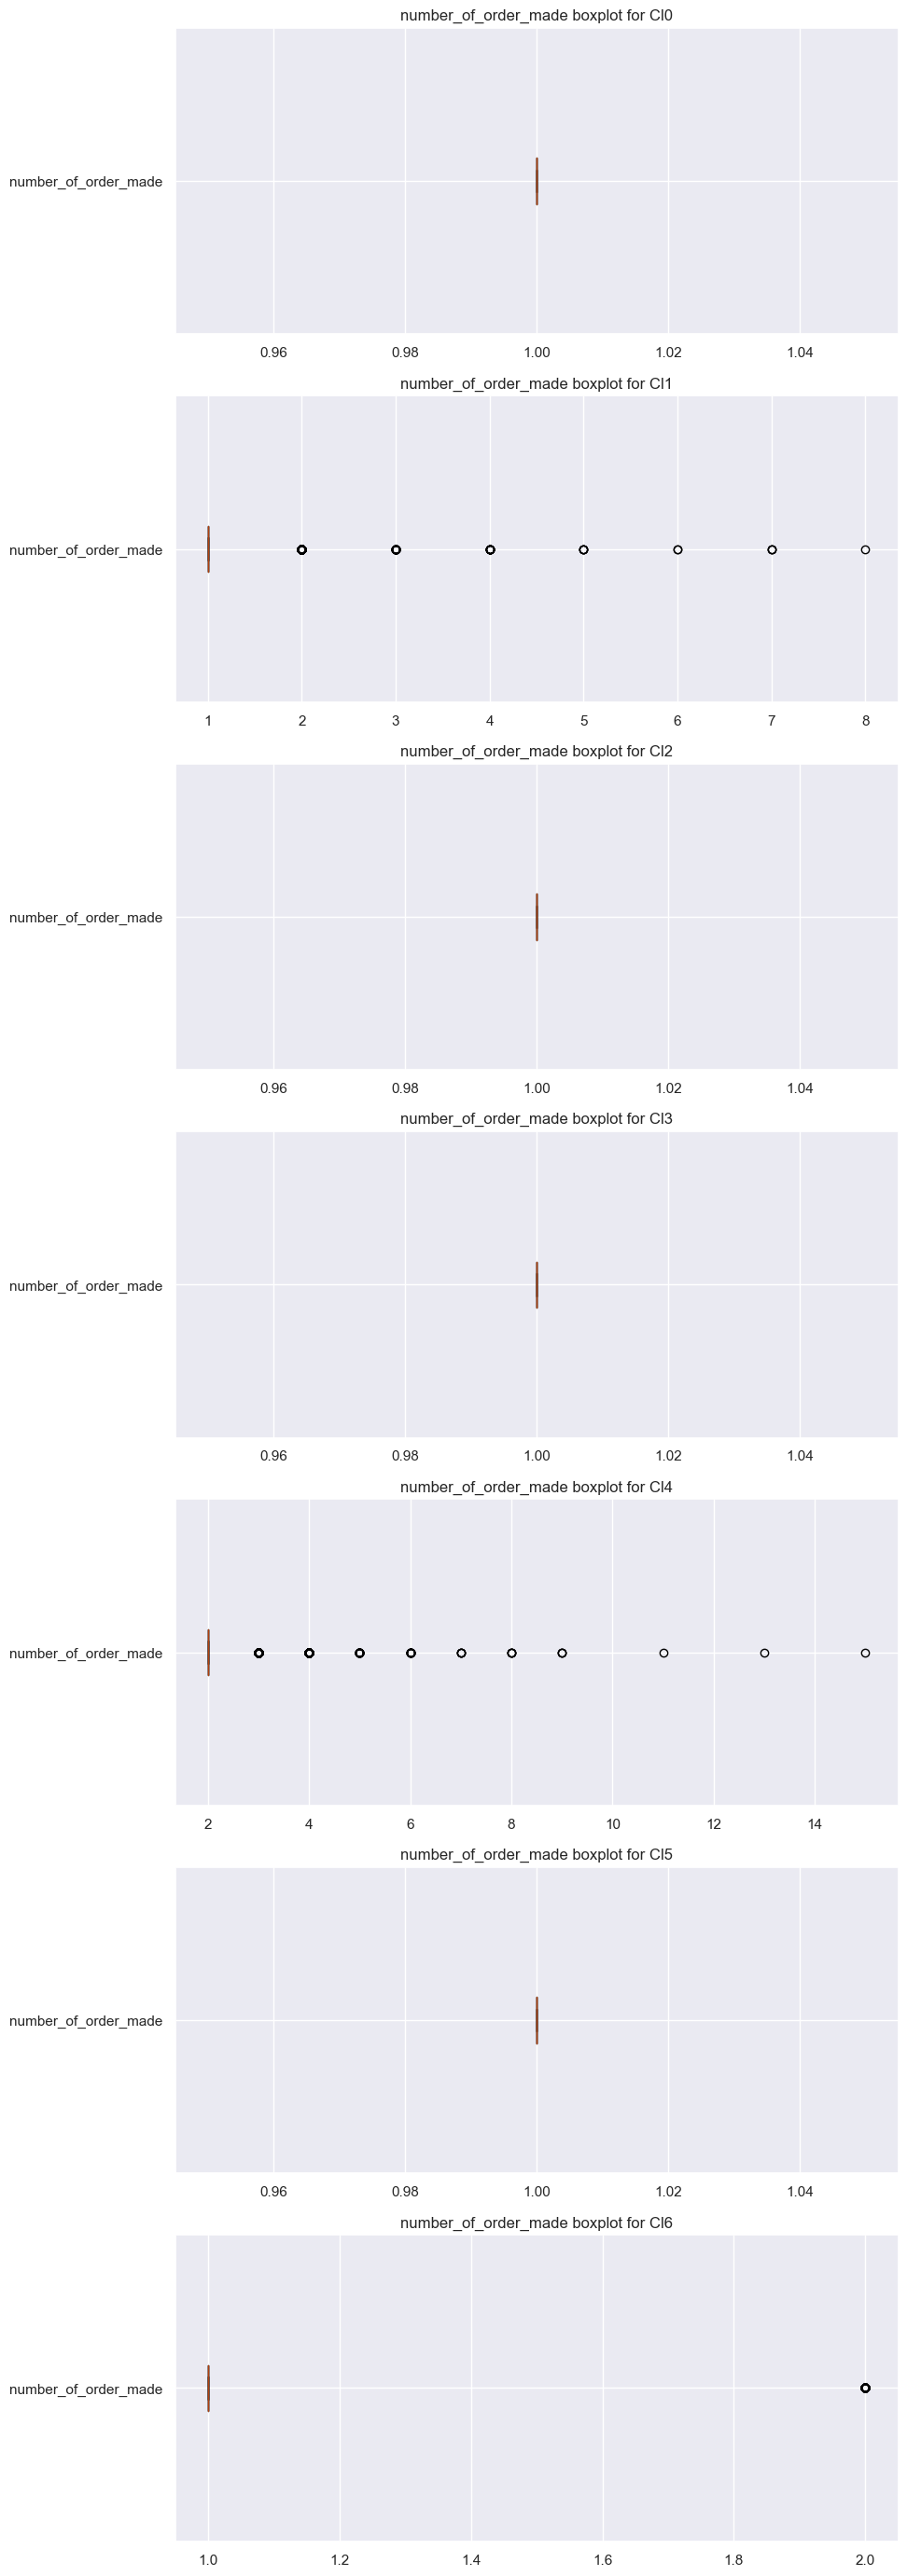

In [26]:
boxplot(df_cluster_final, 1, 'kmean', 'number_of_order_made')

In [78]:
# Le DBSCAN est abandonné, il souffre d'un manque d'utilité : un gros cluster, et de tout petit clusters négligable.

dict_best_values = {}
for i in [2, 4, 8, 16, 24, 48]:
    dict_best_values[f'kmean_totalperiode_{i}_periode_{i}'] = 8

# Une fonction pour le paramétrage du kmean, et la récupération de la meilleur valeur du nb_cluster


def parametrage_kmean(liste_data, liste_nb_cluster_a_test):
    df = pd.DataFrame()
    list_k_values = []
    list_periode_values = []
    for k in range(len(liste_data[:-1])):
        data_cr = scaler(liste_data[k])
        for i in liste_nb_cluster_a_test:
            label_kmean = kmean_for_one(data_cr, i)
            df[f'Kmean_periode_{k+1}_&_k={i}'] = [silhouette_score(data_cr, label_kmean)]
            list_k_values.append(i)
            list_periode_values.append(k+1)
    df = df.T.rename(columns={df.T.columns[0]: 'Silhouette_score'})
    df['k_values'] = list_k_values
    df['periode'] = list_periode_values
    return df


def recup_best_param_kmean(data, nb_periode):
    d = {}
    for i in range(nb_periode-1):
        df = data.loc[data['periode'] == i+1]
        df = df.sort_values(by='Silhouette_score', ascending=False)
        d[f'kmean_totalperiode_{nb_periode}_periode_{i+1}'] = df.iloc[0,1]
    return d




In [81]:
# On applique tout ça aux différentes périodicité prédéfinies. On ,ne le fait pas dans une boucle for pour pouvoir avoir
# différents paramètres testable selon le nombre de période.

for i in [2, 4, 6, 8, 12, 16, 24, 48]:
    nb_periode = i
    liste_data = []
    for i in range(nb_periode):
        liste_data.append(
            pd.read_csv(
                'df_' +
                str(nb_periode) +
                '_' +
                str(i)).drop(
                columns='Unnamed: 0'))

    k2 = parametrage_kmean(liste_data, [5, 6, 7, 8, 9, 10])
    dict_best_values.update(recup_best_param_kmean(k2, nb_periode))

In [89]:
# Et pour finir, on enregistre le tout dans un dataframme. On peut
# maintenant passer à l'étude de tout ces clusterings.

parametres = pd.DataFrame.from_dict(dict_best_values, orient='index', columns = ['number_of_culster'])
parametres.to_csv('parametres.csv')
parametres

,number_of_culster
kmean_totalperiode_2_periode_2,8
kmean_totalperiode_4_periode_4,8
kmean_totalperiode_8_periode_8,8
kmean_totalperiode_16_periode_16,8
kmean_totalperiode_24_periode_24,8
...,...
kmean_totalperiode_48_periode_43,9
kmean_totalperiode_48_periode_44,8
kmean_totalperiode_48_periode_45,8
kmean_totalperiode_48_periode_46,8
